In [1]:
%matplotlib widget

In [2]:
import numpy as np
from scipy.fft import dct, dst, idct

def _mydst(arr, axis=-1):
    tmp = dst(arr, axis=axis)
    res = np.roll(tmp, 1, axis=axis)
    if axis == 0 or axis == -2:
        res[0, :] = 0
    else:
        res[:, 0] = 0
    return res

def fft_invert(uy, ux, LY=np.pi, LX=np.pi):
    """
    Invert a vector field `(ux, uy)` into its corresponding kappa.
    
    This function infers the kappa scalar density field of weak lensing from the
    (noisy) measurements given by the vector field `(ux, uy)`. It is assumed that
    `(ux, uy)` are noisy measurements of the gradient of kappa, and that these
    measurements are carried out on a rectangle of sizes (in appropriate units)
    given by `LX` and `LY`.
    
    This function uses the Fast Fourier technique explained in Lombardi & Bertin
    (1999), A&A 348, 38 (bibcode: 1999A&A...348...38L).
    """
    NY, NX = uy.shape
    MY, MX = ux.shape
    if MX != NX or MY != NY:
        raise ValueError("The u arrays must have the same shapes")
    # sin-cos discrete tranforms of ux and uy
    ox = dct(_mydst(ux, axis=-1), axis=-2)
    oy = _mydst(dct(uy, axis=-1), axis=-2)
    # build the c array
    c = np.zeros((NY, NX))
    IY, IX = np.mgrid[0:NY, 0:NX]
    iX = IX / LX
    iY = IY / LY
    num = np.ones_like(c)
    num[:, 0] /= 2
    num[0, :] /= 2
    num[0, 0] = 0
    den = (iX*iX + iY*iY) * np.pi
    den[0, 0] = 1
    norm = num / den
    c = -(ox * iX + oy * iY) * norm
    # Perform inverse cosine transform to get kappa back
    kappa = idct(idct(c, axis=-1), axis=-2)
    return kappa

In [3]:
LX = 2.5
LY = 1.5
NX = 121
NY = 150

In [4]:
DX = LX / NX
DY = LY / NY

y, x = np.mgrid[0:NY, 0:NX]
x = (x + 0.5) * DX; y = (y + 0.5) * DY

kx = 8
ky = 5
f = 1.0
kappa0 = f * np.cos(kx * x / LX * np.pi) * np.cos(ky * y / LY * np.pi)

uy = -f * np.cos(kx * x / LX * np.pi) * np.sin(ky * y / LY * np.pi) * ky / LY * np.pi
ux = -f * np.sin(kx * x / LX * np.pi) * np.cos(ky * y / LY * np.pi) * kx / LX * np.pi

# Add same curl-like noise: this is the curl of a sin-sin function, so that
# u has the correct boundary conditions (u \cdot n = 0 on the border).

lx = 2
ly = 3
g = 1.0

ux += g*np.sin(lx * x / LX * np.pi) * np.cos(ly * y / LY * np.pi) * ly / LY * np.pi
uy -= g*np.cos(lx * x / LX * np.pi) * np.sin(ly * y / LY * np.pi) * lx / LX * np.pi

In [5]:
kappa = fft_invert(uy, ux, LX=LX, LY=LY)

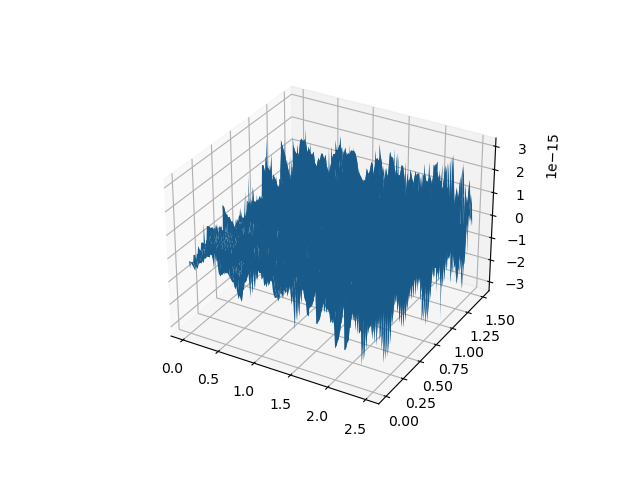

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(x, y, kappa - kappa0)